In [1]:
import os

# Création des dossiers nécessaires
os.makedirs("../data", exist_ok=True)
os.makedirs("../results", exist_ok=True)
os.makedirs("../plots", exist_ok=True)

def fetch_sp500_tickers() -> None:
    """
    Récupère la liste des tickers composant le S&P 500 depuis Wikipedia et les sauvegarde dans un fichier CSV.
    """
    import pandas as pd
    import urllib.request

    wiki_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36'}
    req = urllib.request.Request(wiki_url, headers=headers)
    with urllib.request.urlopen(req) as response:
        sp500_table = pd.read_html(response.read())[0]

    tickers = sp500_table['Symbol'].tolist()
    tickers = [ticker.replace('.', '-') for ticker in tickers]

    print(f"✓ {len(tickers)} tickers récupérés depuis Wikipedia")
    print(f"  Exemples : {', '.join(tickers[:5])}")
    tickers_path = '../data/sp500_tickers.csv'
    pd.DataFrame({'ticker': tickers}).to_csv(tickers_path, index=False)
    print(f"  Fichier sauvegardé : {tickers_path}")

if __name__ == "__main__":

    print("=" * 80)
    print("PIPELINE DE PRÉVISION S&P 500 - RENDEMENTS PONDÉRÉS PAR LIQUIDITÉ")
    print("=" * 80)
    print("\nÉTAPE 1: RÉCUPÉRATION DES TICKERS S&P 500")
    fetch_sp500_tickers()
    

PIPELINE DE PRÉVISION S&P 500 - RENDEMENTS PONDÉRÉS PAR LIQUIDITÉ

ÉTAPE 1: RÉCUPÉRATION DES TICKERS S&P 500
✓ 503 tickers récupérés depuis Wikipedia
  Exemples : MMM, AOS, ABT, ABBV, ACN
  Fichier sauvegardé : ../data/sp500_tickers.csv


In [2]:
def download_sp500_data() -> None:
    """
    Télécharge les données historiques de tous les tickers S&P 500 via yfinance et sauvegarde dans un CSV.
    Utilise les prix ajustés pour éviter les sauts de split/dividende.
    """
    import yfinance as yf
    import pandas as pd
    from datetime import datetime, timedelta

    tickers_df = pd.read_csv('../data/sp500_tickers.csv')
    tickers = tickers_df['ticker'].tolist()

    end_date = datetime.now()
    start_date = end_date - timedelta(days=10 * 365)

    print(f"Téléchargement des données pour {len(tickers)} tickers...")
    print(f"Période : {start_date.date()} → {end_date.date()}")

    data_list = []
    failed_tickers = []

    for i, ticker in enumerate(tickers):
        try:
            ticker_data = yf.download(
                ticker,
                start=start_date,
                end=end_date,
                progress=False,
                auto_adjust=True  # prix ajustés
            )
            if ticker_data is not None and not ticker_data.empty:
                if isinstance(ticker_data.columns, pd.MultiIndex):
                    ticker_data.columns = ticker_data.columns.get_level_values(0)
                ticker_df = pd.DataFrame({
                    'date': ticker_data.index,
                    'ticker': ticker,
                    'open': ticker_data['Open'],
                    'closing': ticker_data['Close'],
                    'volume': ticker_data['Volume']
                })
                data_list.append(ticker_df)
            else:
                failed_tickers.append(ticker)
        except Exception:
            failed_tickers.append(ticker)

        if (i + 1) % 50 == 0:
            print(f"  Progression : {i + 1}/{len(tickers)} tickers téléchargés...")

    if data_list:
        dataset = pd.concat(data_list, ignore_index=True)
        dataset = dataset.dropna()
        output_path = '../data/dataset.csv'
        dataset.to_csv(output_path, index=False)
        print(f"\n✓ Téléchargement terminé :")
        print(f"  {len(data_list)} tickers réussis")
        print(f"  {len(failed_tickers)} tickers échoués")
        print(f"  {len(dataset)} observations totales")
        print(f"  Fichier sauvegardé : {output_path}")
        if failed_tickers:
            print(f"\n⚠ Tickers échoués : {', '.join(failed_tickers[:10])}")
            if len(failed_tickers) > 10:
                print(f"   ... et {len(failed_tickers) - 10} autres")
    else:
        raise RuntimeError("Aucune donnée téléchargée.")
    

if __name__ == "__main__":
    print("\nÉTAPE 2: TÉLÉCHARGEMENT DES DONNÉES HISTORIQUES")
    download_sp500_data()


ÉTAPE 2: TÉLÉCHARGEMENT DES DONNÉES HISTORIQUES
Téléchargement des données pour 503 tickers...
Période : 2015-11-07 → 2025-11-04
  Progression : 50/503 tickers téléchargés...
  Progression : 100/503 tickers téléchargés...
  Progression : 150/503 tickers téléchargés...
  Progression : 200/503 tickers téléchargés...
  Progression : 250/503 tickers téléchargés...
  Progression : 300/503 tickers téléchargés...
  Progression : 350/503 tickers téléchargés...
  Progression : 400/503 tickers téléchargés...
  Progression : 450/503 tickers téléchargés...
  Progression : 500/503 tickers téléchargés...

✓ Téléchargement terminé :
  503 tickers réussis
  0 tickers échoués
  1227526 observations totales
  Fichier sauvegardé : ../data/dataset.csv


In [3]:
import pandas as pd
import numpy as np


def data_quality_analysis():
    """
    Analyse la qualité des données et affiche un résumé.
    """
    raw_df = pd.read_csv('../data/dataset.csv')
    raw_df['date'] = pd.to_datetime(raw_df['date'])

    print("=" * 60)
    print("ANALYSE DE LA QUALITÉ DES DONNÉES")
    print("=" * 60)

    print(f"\n1. STATISTIQUES GÉNÉRALES")
    print(f"   Nombre total d'observations : {len(raw_df):,}")
    print(f"   Nombre de tickers uniques : {raw_df['ticker'].nunique()}")
    print(f"   Période : {raw_df['date'].min().date()} → {raw_df['date'].max().date()}")
    print(f"   Nombre de dates uniques : {raw_df['date'].nunique()}")

    print(f"\n2. VALEURS MANQUANTES")
    missing = raw_df.isnull().sum()
    for col in ['date', 'ticker', 'open', 'closing', 'volume']:
        print(f"   {col:<8}: {missing[col]} ({missing[col] / len(raw_df) * 100:.2f}%)")

    print(f"\n3. VALEURS ABERRANTES")
    zero_open = (raw_df['open'] <= 0).sum()
    zero_closing = (raw_df['closing'] <= 0).sum()
    zero_volume = (raw_df['volume'] <= 0).sum()
    print(f"   Prix d'ouverture <= 0 : {zero_open}")
    print(f"   Prix de clôture <= 0 : {zero_closing}")
    print(f"   Volume <= 0 : {zero_volume}")

    print(f"\n4. DISTRIBUTION PAR TICKER")
    obs_per_ticker = raw_df.groupby('ticker').size()
    max_obs = obs_per_ticker.max()
    min_obs = obs_per_ticker.min()
    print(f"   Observations min : {min_obs}")
    print(f"   Observations max : {max_obs}")
    print(f"   Observations moyennes : {obs_per_ticker.mean():.0f}")
    print(f"   Observations médianes : {obs_per_ticker.median():.0f}")

    tickers_incomplete = (obs_per_ticker < max_obs).sum()
    print(f"\n   ⚠ {tickers_incomplete} tickers ont moins de {max_obs} observations")
    print(f"     ({tickers_incomplete / len(obs_per_ticker) * 100:.1f}% des tickers)")

    print(f"\n5. TICKERS AVEC LE MOINS D'OBSERVATIONS (top 10)")
    least_obs = obs_per_ticker.nsmallest(10)
    for ticker, count in least_obs.items():
        pct_complete = (count / max_obs) * 100
        print(f"   {ticker:6s} : {count:4d} observations ({pct_complete:.1f}% complet)")

    print(f"\n6. TICKERS AVEC VOLUMES MOYENS FAIBLES (top 10)")
    avg_volume = raw_df.groupby('ticker')['volume'].mean().nsmallest(10)
    for ticker, vol in avg_volume.items():
        print(f"   {ticker:6s} : {vol:,.0f} volume moyen")


if __name__ == "__main__":
    print("\nÉTAPE 3: ANALYSE DE LA QUALITÉ DES DONNÉES")
    data_quality_analysis()


ÉTAPE 3: ANALYSE DE LA QUALITÉ DES DONNÉES
ANALYSE DE LA QUALITÉ DES DONNÉES

1. STATISTIQUES GÉNÉRALES
   Nombre total d'observations : 1,227,526
   Nombre de tickers uniques : 503
   Période : 2015-11-09 → 2025-11-03
   Nombre de dates uniques : 2511

2. VALEURS MANQUANTES
   date    : 0 (0.00%)
   ticker  : 0 (0.00%)
   open    : 0 (0.00%)
   closing : 0 (0.00%)
   volume  : 0 (0.00%)

3. VALEURS ABERRANTES
   Prix d'ouverture <= 0 : 0
   Prix de clôture <= 0 : 0
   Volume <= 0 : 1955

4. DISTRIBUTION PAR TICKER
   Observations min : 11
   Observations max : 2511
   Observations moyennes : 2440
   Observations médianes : 2511

   ⚠ 35 tickers ont moins de 2511 observations
     (7.0% des tickers)

5. TICKERS AVEC LE MOINS D'OBSERVATIONS (top 10)
   SOLS   :   11 observations (0.4% complet)
   GEV    :  403 observations (16.0% complet)
   SOLV   :  404 observations (16.1% complet)
   VLTO   :  523 observations (20.8% complet)
   KVUE   :  628 observations (25.0% complet)
   GEHC   :

In [4]:
def filter_incomplete_tickers():
    """
    Filtre les tickers avec moins de 2510 observations.
    Sauvegarde le dataset filtré.
    """
    raw_df = pd.read_csv('../data/dataset.csv')
    raw_df['date'] = pd.to_datetime(raw_df['date'])

    print("=" * 60)
    print("FILTRAGE DES TICKERS INCOMPLETS")
    print("=" * 60)

    obs_per_ticker = raw_df.groupby('ticker').size()
    print(f"\nAvant filtrage :")
    print(f"  Nombre de tickers : {len(obs_per_ticker)}")
    print(f"  Observations totales : {len(raw_df):,}")

    MIN_OBS = 2510

    valid_tickers = obs_per_ticker[obs_per_ticker >= MIN_OBS].index
    removed_tickers = obs_per_ticker[obs_per_ticker < MIN_OBS]

    print(f"\nCritère : nombre d'observations >= {MIN_OBS}")
    print(f"  Tickers conservés : {len(valid_tickers)}")
    print(f"  Tickers supprimés : {len(removed_tickers)}")

    if len(removed_tickers) > 0:
        print(f"\nTickers supprimés :")
        for ticker, count in removed_tickers.sort_values().items():
            print(f"  {ticker:6s} : {count:4d} observations")

    filtered_df = raw_df[raw_df['ticker'].isin(valid_tickers)].reset_index(drop=True)

    output_path = '../data/dataset_filtered.csv'
    filtered_df.to_csv(output_path, index=False)

    print(f"\nAprès filtrage :")
    print(f"  Nombre de tickers : {filtered_df['ticker'].nunique()}")
    print(f"  Observations totales : {len(filtered_df):,}")
    print(f"  Fichier sauvegardé : {output_path}")
    print("=" * 60)

if __name__ == "__main__":
    print("\nÉTAPE 4: FILTRAGE DES TICKERS INCOMPLETS")
    filter_incomplete_tickers()


ÉTAPE 4: FILTRAGE DES TICKERS INCOMPLETS
FILTRAGE DES TICKERS INCOMPLETS

Avant filtrage :
  Nombre de tickers : 503
  Observations totales : 1,227,526

Critère : nombre d'observations >= 2510
  Tickers conservés : 468
  Tickers supprimés : 35

Tickers supprimés :
  SOLS   :   11 observations
  GEV    :  403 observations
  SOLV   :  404 observations
  VLTO   :  523 observations
  KVUE   :  628 observations
  GEHC   :  723 observations
  CEG    :  952 observations
  HOOD   : 1072 observations
  APP    : 1145 observations
  COIN   : 1146 observations
  EXE    : 1189 observations
  ABNB   : 1230 observations
  DASH   : 1231 observations
  PLTR   : 1280 observations
  CARR   : 1415 observations
  OTIS   : 1415 observations
  DDOG   : 1540 observations
  CRWD   : 1609 observations
  CTVA   : 1621 observations
  UBER   : 1631 observations
  DOW    : 1667 observations
  FOX    : 1672 observations
  FOXA   : 1673 observations
  MRNA   : 1736 observations
  DAY    : 1892 observations
  VICI   

In [5]:
def compute_weighted_log_returns():
    """
    Calcule les poids de liquidité (moyenne volume*prix) et les rendements logarithmiques agrégés pondérés.
    Sauvegarde les poids par ticker et la série agrégée.
    """
    print("=" * 60)
    print("CALCUL DES POIDS DE LIQUIDITÉ ET RENDEMENTS PONDÉRÉS")
    print("=" * 60)

    raw_df = pd.read_csv('../data/dataset_filtered.csv')
    raw_df['date'] = pd.to_datetime(raw_df['date'])
    raw_df = raw_df.sort_values(['ticker', 'date']).reset_index(drop=True)

    liquidity_metrics = (
        raw_df.groupby('ticker')[['volume', 'closing']]
        .mean()
        .rename(columns={'volume': 'mean_volume', 'closing': 'mean_price'})
    )
    liquidity_metrics['liquidity_score'] = (
        liquidity_metrics['mean_volume'] * liquidity_metrics['mean_price']
    )

    total_liquidity = liquidity_metrics['liquidity_score'].sum()
    if total_liquidity == 0:
        raise ValueError("Somme des scores de liquidité nulle : vérifier les données.")

    liquidity_metrics['weight'] = liquidity_metrics['liquidity_score'] / total_liquidity

    weights_path = '../data/liquidity_weights.csv'
    liquidity_metrics[['mean_volume', 'mean_price', 'liquidity_score', 'weight']].to_csv(
        weights_path, index=True
    )

    raw_df['log_return'] = raw_df.groupby('ticker')['closing'].transform(
        lambda x: np.log(x / x.shift(1))
    )
    returns_df = raw_df.dropna(subset=['log_return'])

    # Rendements pondérés
    weighted_returns = returns_df.merge(
        liquidity_metrics[['weight']], left_on='ticker', right_index=True
    )
    daily_weight_totals = (
        weighted_returns.groupby('date')['weight'].sum().rename('weight_sum')
    )
    weighted_returns = weighted_returns.merge(daily_weight_totals, on='date', how='left')

    if (weighted_returns['weight_sum'] <= 0).any():
        bad_dates = weighted_returns.loc[weighted_returns['weight_sum'] <= 0, 'date'].dt.strftime('%Y-%m-%d').unique()
        raise ValueError(
            "Somme des poids nulle ou négative pour certaines dates : "
            + ', '.join(bad_dates[:5])
        )

    weighted_returns['normalized_weight'] = (
        weighted_returns['weight'] / weighted_returns['weight_sum']
    )
    weighted_returns['weighted_contribution'] = (
        weighted_returns['log_return'] * weighted_returns['normalized_weight']
    )
    aggregated = weighted_returns.groupby('date', as_index=False).agg(
        weighted_log_return=('weighted_contribution', 'sum')
    )

    # Agrégation pondérée des prix open/close (pour le backtest)
    raw_weighted = returns_df.merge(
        liquidity_metrics[['weight']], left_on='ticker', right_index=True
    )
    raw_weighted = raw_weighted.merge(daily_weight_totals, on='date', how='left')
    raw_weighted['normalized_weight'] = (
        raw_weighted['weight'] / raw_weighted['weight_sum']
    )

    raw_aggregated = raw_weighted.groupby('date', as_index=False).agg(
        weighted_open=('open', lambda x: np.average(x, weights=raw_weighted.loc[x.index, 'normalized_weight'])),
        weighted_closing=('closing', lambda x: np.average(x, weights=raw_weighted.loc[x.index, 'normalized_weight']))
    )

    aggregated = aggregated.merge(raw_aggregated, on='date')

    agg_path = '../data/weighted_log_returns.csv'
    aggregated.to_csv(agg_path, index=False)

    print(f"Poids normalisés exportés : {weights_path}")
    print(f"Série pondérée exportée : {agg_path}")
    print(f"Nombre de dates : {len(aggregated)}")
    print(f"Période : {aggregated['date'].min().date()} → {aggregated['date'].max().date()}")

if __name__ == "__main__":
    print("\nÉTAPE 5: CALCUL DES POIDS DE LIQUIDITÉ ET RENDEMENTS PONDÉRÉS")
    compute_weighted_log_returns()


ÉTAPE 5: CALCUL DES POIDS DE LIQUIDITÉ ET RENDEMENTS PONDÉRÉS
CALCUL DES POIDS DE LIQUIDITÉ ET RENDEMENTS PONDÉRÉS
Poids normalisés exportés : ../data/liquidity_weights.csv
Série pondérée exportée : ../data/weighted_log_returns.csv
Nombre de dates : 2510
Période : 2015-11-10 → 2025-11-03


In [6]:
from typing import Dict, cast
from statsmodels.tsa.stattools import adfuller


def adf_test():
    """
    Effectue le test ADF sur la série pondérée.
    """
    print("=" * 60)
    print("TEST DE DICKEY-FULLER AUGMENTÉ (ADF)")
    print("=" * 60)

    aggregated_returns = pd.read_csv(
        '../data/weighted_log_returns.csv', parse_dates=['date']
    ).set_index('date')
    weighted_series = aggregated_returns['weighted_log_return'].dropna()

    adf_result = adfuller(weighted_series, autolag='AIC')
    if len(adf_result) < 5:
        raise RuntimeError("Résultat ADF inattendu : moins de 5 composantes.")

    adf_statistic = float(adf_result[0])
    p_value = float(adf_result[1])
    used_lag = int(adf_result[2])
    n_obs = int(adf_result[3])
    critical_values = cast(Dict[str, float], adf_result[4])

    print("TEST DE DICKEY-FULLER AUGMENTÉ (ADF)")
    print(f"Statistique ADF : {adf_statistic:.4f}")
    print(f"p-value : {p_value:.6f}")
    print(f"Retards utilisés : {used_lag}")
    print(f"Observations : {n_obs}")
    print("Seuils critiques :")
    for level, value in critical_values.items():
        print(f"  {level}: {value:.4f}")

    if p_value < 0.05:
        print("\n✓ Série stationnaire au seuil de 5%")
    else:
        print("\n⚠ Série non stationnaire : différenciation potentiellement nécessaire")

if __name__ == "__main__":
    print("\nÉTAPE 6: TEST DE STATIONNARITÉ ADF")
    adf_test()


ÉTAPE 6: TEST DE STATIONNARITÉ ADF
TEST DE DICKEY-FULLER AUGMENTÉ (ADF)
TEST DE DICKEY-FULLER AUGMENTÉ (ADF)
Statistique ADF : -16.0603
p-value : 0.000000
Retards utilisés : 8
Observations : 2501
Seuils critiques :
  1%: -3.4330
  5%: -2.8627
  10%: -2.5674

✓ Série stationnaire au seuil de 5%


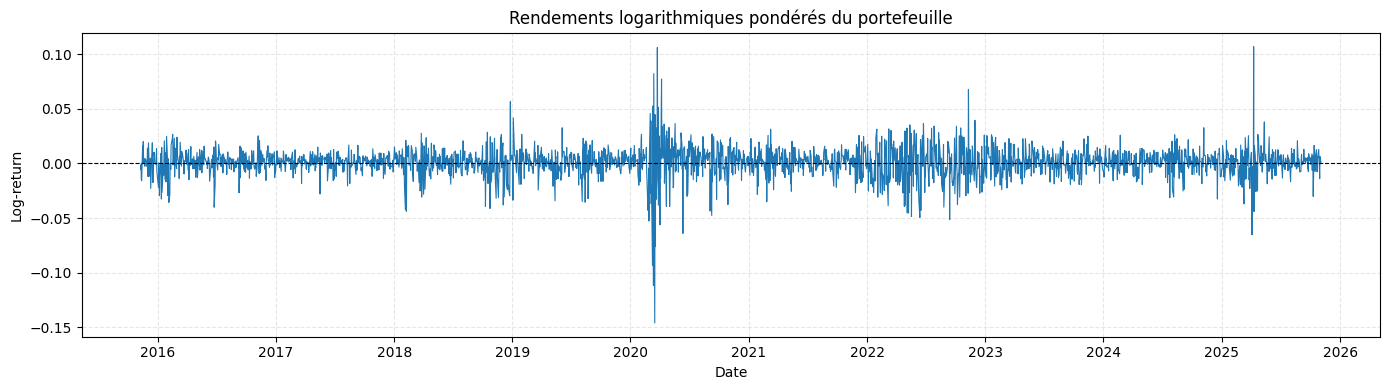

In [7]:
import matplotlib.pyplot as plt


def plot_weighted_series():
    """
    Trace la série temporelle des rendements logarithmiques pondérés.
    """
    aggregated_returns = pd.read_csv('../data/weighted_log_returns.csv', parse_dates=['date']).set_index('date')
    weighted_series = aggregated_returns['weighted_log_return'].dropna()

    _, ax = plt.subplots(figsize=(14, 4))
    ax.plot(weighted_series.index, weighted_series, linewidth=0.8)
    ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
    ax.set_title('Rendements logarithmiques pondérés du portefeuille')
    ax.set_ylabel('Log-return')
    ax.set_xlabel('Date')
    ax.grid(alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    plot_weighted_series()

In [8]:
from statsmodels.tsa.stattools import acf, pacf


def compute_acf_pacf():
    """
    Calcule et affiche les valeurs ACF et PACF pour la série pondérée.
    """
    print("=" * 60)
    print("STATISTIQUES D'AUTOCORRÉLATION")
    print("=" * 60)

    aggregated_returns = pd.read_csv('../data/weighted_log_returns.csv', parse_dates=['date']).set_index('date')
    weighted_series = aggregated_returns['weighted_log_return'].dropna()

    acf_values = acf(weighted_series, nlags=30, fft=False)
    pacf_values = pacf(weighted_series, nlags=30, method='ywm')

    print("AUTOCORRÉLATION (ACF) - Premiers retards")
    for lag in range(1, 11):
        print(f"  Lag {lag:2d}: {acf_values[lag]:7.4f}")

    print("\nAUTOCORRÉLATION PARTIELLE (PACF) - Premiers retards")
    for lag in range(1, 11):
        print(f"  Lag {lag:2d}: {pacf_values[lag]:7.4f}")

if __name__ == "__main__":
    print("\nÉTAPE 7: CALCUL DES STATISTIQUES D'AUTOCORRÉLATION")
    compute_acf_pacf()


ÉTAPE 7: CALCUL DES STATISTIQUES D'AUTOCORRÉLATION
STATISTIQUES D'AUTOCORRÉLATION
AUTOCORRÉLATION (ACF) - Premiers retards
  Lag  1: -0.1098
  Lag  2:  0.0958
  Lag  3: -0.0198
  Lag  4: -0.0314
  Lag  5:  0.0244
  Lag  6: -0.0932
  Lag  7:  0.1143
  Lag  8: -0.0970
  Lag  9:  0.1048
  Lag 10: -0.0370

AUTOCORRÉLATION PARTIELLE (PACF) - Premiers retards
  Lag  1: -0.1098
  Lag  2:  0.0848
  Lag  3: -0.0009
  Lag  4: -0.0424
  Lag  5:  0.0192
  Lag  6: -0.0839
  Lag  7:  0.0946
  Lag  8: -0.0645
  Lag  9:  0.0742
  Lag 10: -0.0125


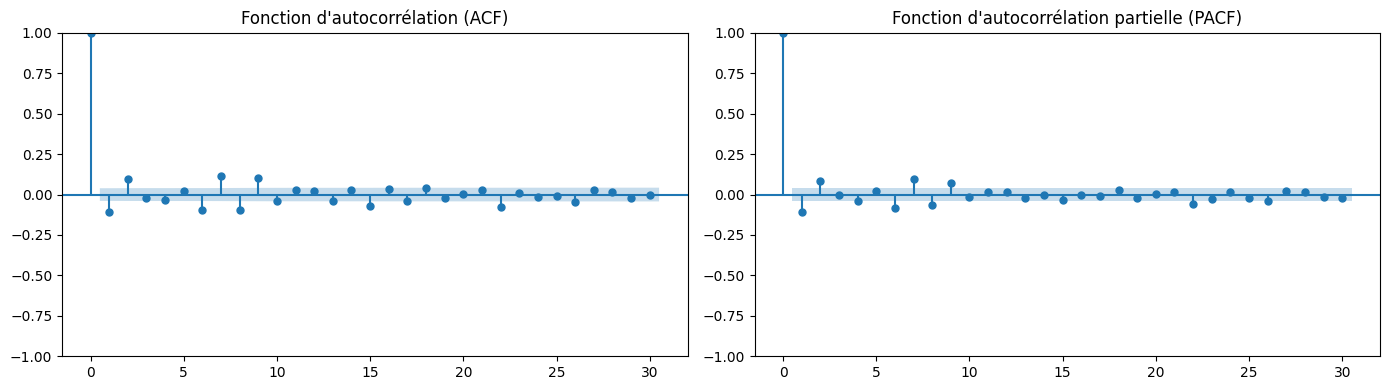

In [9]:
from statsmodels.graphics.tsaplots import plot_acf as plot_acf_func, plot_pacf as plot_pacf_func


def plot_acf_pacf():
    """
    Trace les fonctions d'autocorrélation (ACF) et d'autocorrélation partielle (PACF).
    """
    aggregated_returns = pd.read_csv('../data/weighted_log_returns.csv', parse_dates=['date']).set_index('date')
    weighted_series = aggregated_returns['weighted_log_return'].dropna()

    _, axes = plt.subplots(1, 2, figsize=(14, 4))

    plot_acf_func(weighted_series, lags=30, ax=axes[0])
    axes[0].set_title('Fonction d\'autocorrélation (ACF)')

    plot_pacf_func(weighted_series, lags=30, ax=axes[1], method='ywm')
    axes[1].set_title('Fonction d\'autocorrélation partielle (PACF)')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    plot_acf_pacf()

In [10]:
def split_train_test():
    """
    Split temporel 80% train / 20% test.
    Exporte un CSV avec colonne 'split'.
    """
    print("=" * 60)
    print("SPLIT TEMPOREL TRAIN/TEST (80/20)")
    print("=" * 60)

    aggregated_returns = pd.read_csv('../data/weighted_log_returns.csv', parse_dates=['date'])
    aggregated_returns = aggregated_returns.dropna(subset=['weighted_log_return'])
    aggregated_returns = aggregated_returns.sort_values('date').reset_index(drop=True)

    n_total = len(aggregated_returns)
    n_train = int(n_total * 0.8)

    train_df = aggregated_returns.iloc[:n_train].copy()
    train_df['split'] = 'train'

    test_df = aggregated_returns.iloc[n_train:].copy()
    test_df['split'] = 'test'

    split_df = pd.concat([train_df, test_df], ignore_index=True)
    split_path = '../data/weighted_log_returns_split.csv'
    split_df.to_csv(split_path, index=False)

    print(f"Nombre total d'observations : {n_total}")
    print(f"Train set : {len(train_df)} observations ({len(train_df) / n_total * 100:.1f}%)")
    print(f"  Période : {train_df['date'].min().date()} → {train_df['date'].max().date()}")
    print(f"Test set : {len(test_df)} observations ({len(test_df) / n_total * 100:.1f}%)")
    print(f"  Période : {test_df['date'].min().date()} → {test_df['date'].max().date()}")
    print(f"\nFichier exporté : {split_path}")

if __name__ == "__main__":
    print("\nÉTAPE 8: SPLIT TEMPOREL TRAIN/TEST (80/20)")
    split_train_test()


ÉTAPE 8: SPLIT TEMPOREL TRAIN/TEST (80/20)
SPLIT TEMPOREL TRAIN/TEST (80/20)
Nombre total d'observations : 2510
Train set : 2008 observations (80.0%)
  Période : 2015-11-10 → 2023-11-01
Test set : 502 observations (20.0%)
  Période : 2023-11-02 → 2025-11-03

Fichier exporté : ../data/weighted_log_returns_split.csv


In [11]:
def load_train_test_data():
    """
    Charge les données avec split train/test et retourne les séries.
    """
    split_data = pd.read_csv('../data/weighted_log_returns_split.csv', parse_dates=['date'])

    train_data = split_data[split_data['split'] == 'train'].copy()
    test_data = split_data[split_data['split'] == 'test'].copy()

    train_series = train_data.set_index('date')['weighted_log_return']
    test_series = test_data.set_index('date')['weighted_log_return']

    print("=" * 60)
    print("DONNÉES CHARGÉES")
    print("=" * 60)
    print(f"\nTrain set :")
    print(f"  Nombre d'observations : {len(train_series)}")
    print(f"  Période : {train_series.index.min().date()} → {train_series.index.max().date()}")

    print(f"\nTest set :")
    print(f"  Nombre d'observations : {len(test_series)}")
    print(f"  Période : {test_series.index.min().date()} → {test_series.index.max().date()}")

    print(f"\nStatistiques descriptives (train) :")
    print(f"  Moyenne : {train_series.mean():.6f}")
    print(f"  Écart-type : {train_series.std():.6f}")
    print(f"  Min : {train_series.min():.6f}")
    print(f"  Max : {train_series.max():.6f}")
    print("=" * 60)

    return train_series, test_series

if __name__ == "__main__":
    print("\nÉTAPE 9: CHARGEMENT DES DONNÉES TRAIN/TEST")
    load_train_test_data()


ÉTAPE 9: CHARGEMENT DES DONNÉES TRAIN/TEST
DONNÉES CHARGÉES

Train set :
  Nombre d'observations : 2008
  Période : 2015-11-10 → 2023-11-01

Test set :
  Nombre d'observations : 502
  Période : 2023-11-02 → 2025-11-03

Statistiques descriptives (train) :
  Moyenne : 0.000686
  Écart-type : 0.014215
  Min : -0.145888
  Max : 0.106021


In [12]:
def optimize_arima_models(train_series: pd.Series, test_series: pd.Series):
    """
    Recherche exhaustive des meilleurs paramètres ARIMA via grille de recherche.
    Optimisation basée sur AIC et BIC. Les modèles optimaux sont exportés
    (validation rolling ensuite).
    """
    import warnings
    import itertools
    import pandas as pd
    import json
    from statsmodels.tsa.arima.model import ARIMA
    from typing import List, Dict

    warnings.filterwarnings('ignore')

    p_range = range(0, 6)
    d_range = range(0, 3)
    q_range = range(0, 6)

    param_combinations = list(itertools.product(p_range, d_range, q_range))

    print("=" * 60)
    print("OPTIMISATION DES HYPERPARAMÈTRES ARIMA")
    print("=" * 60)
    print(f"\nGrille de recherche :")
    print(f"  p (AR) : {list(p_range)}")
    print(f"  d (I)  : {list(d_range)}")
    print(f"  q (MA) : {list(q_range)}")
    print(f"  Total de combinaisons : {len(param_combinations)}")

    results: List[Dict] = []

    print(f"\nDébut de l'optimisation...")
    print(f"  (peut être long)")

    for idx, (p, d, q) in enumerate(param_combinations, 1):
        try:
            model = ARIMA(train_series, order=(p, d, q))
            fitted_model = model.fit()

            results.append({
                'p': p,
                'd': d,
                'q': q,
                'aic': fitted_model.aic,
                'bic': fitted_model.bic,
                'params': f"ARIMA({p},{d},{q})"
            })

            if idx % 20 == 0:
                print(f"  Progression : {idx}/{len(param_combinations)} modèles testés...")
        except Exception:
            continue

    print(f"\n✓ Optimisation terminée :")
    print(f"  {len(results)} modèles convergés sur {len(param_combinations)} tentatives")
    print("=" * 60)

    results_df = pd.DataFrame(results)
    if results_df.empty:
        raise RuntimeError(
            "Aucun modèle ARIMA n'a convergé : ajuster la grille ou vérifier la série."
        )
    results_df = results_df.sort_values('aic').reset_index(drop=True)

    print("=" * 60)
    print("TOP 10 MODÈLES SELON AIC")
    print("=" * 60)
    print(results_df.head(10).to_string(index=False))

    print("\n" + "=" * 60)
    print("TOP 10 MODÈLES SELON BIC")
    print("=" * 60)
    results_bic = results_df.sort_values('bic').reset_index(drop=True)
    print(results_bic.head(10).to_string(index=False))

    best_aic_model = results_df.iloc[0]
    best_bic_model = results_bic.iloc[0]

    print("\n" + "=" * 60)
    print("MODÈLES OPTIMAUX")
    print("=" * 60)
    print(f"\nMeilleur modèle (AIC) :")
    print(f"  Paramètres : ARIMA({best_aic_model['p']}, {best_aic_model['d']}, {best_aic_model['q']})")
    print(f"  AIC : {best_aic_model['aic']:.4f}")
    print(f"  BIC : {best_aic_model['bic']:.4f}")

    print(f"\nMeilleur modèle (BIC) :")
    print(f"  Paramètres : ARIMA({best_bic_model['p']}, {best_bic_model['d']}, {best_bic_model['q']})")
    print(f"  AIC : {best_bic_model['aic']:.4f}")
    print(f"  BIC : {best_bic_model['bic']:.4f}")

    if (best_aic_model['p'] == best_bic_model['p'] and
        best_aic_model['d'] == best_bic_model['d'] and
        best_aic_model['q'] == best_bic_model['q']):
        print(f"\n✓ AIC et BIC convergent vers le même modèle")
    else:
        print(f"\n⚠ AIC et BIC suggèrent des modèles différents")

    results_path = '../results/arima_optimization_results.csv'
    results_df.to_csv(results_path, index=False)

    best_models = {
        'best_aic': {
            'params': f"ARIMA({int(best_aic_model['p'])}, {int(best_aic_model['d'])}, {int(best_aic_model['q'])})",
            'p': int(best_aic_model['p']),
            'd': int(best_aic_model['d']),
            'q': int(best_aic_model['q']),
            'aic': float(best_aic_model['aic']),
            'bic': float(best_aic_model['bic'])
        },
        'best_bic': {
            'params': f"ARIMA({int(best_bic_model['p'])}, {int(best_bic_model['d'])}, {int(best_bic_model['q'])})",
            'p': int(best_bic_model['p']),
            'd': int(best_bic_model['d']),
            'q': int(best_bic_model['q']),
            'aic': float(best_bic_model['aic']),
            'bic': float(best_bic_model['bic'])
        },
        'total_models_tested': len(param_combinations),
        'models_converged': len(results_df),
        'train_size': len(train_series),
        'test_size': len(test_series)
    }

    best_models_path = '../results/arima_best_models.json'
    with open(best_models_path, 'w') as f:
        json.dump(best_models, f, indent=2)

    print("=" * 60)
    print("EXPORT DES RÉSULTATS")
    print("=" * 60)
    print(f"\n✓ Tous les résultats exportés : {results_path}")
    print(f"✓ Meilleurs modèles exportés : {best_models_path}")
    print("=" * 60)

    return results_df, best_aic_model, best_bic_model

if __name__ == "__main__":
    print("\nÉTAPE 10: OPTIMISATION DES HYPERPARAMÈTRES ARIMA")
    train_series, test_series = load_train_test_data()
    print("\nÉTAPE 11: OPTIMISATION DES HYPERPARAMÈTRES ARIMA")
    results_df, best_aic_model, best_bic_model = optimize_arima_models(train_series, test_series)


ÉTAPE 10: OPTIMISATION DES HYPERPARAMÈTRES ARIMA
DONNÉES CHARGÉES

Train set :
  Nombre d'observations : 2008
  Période : 2015-11-10 → 2023-11-01

Test set :
  Nombre d'observations : 502
  Période : 2023-11-02 → 2025-11-03

Statistiques descriptives (train) :
  Moyenne : 0.000686
  Écart-type : 0.014215
  Min : -0.145888
  Max : 0.106021

ÉTAPE 11: OPTIMISATION DES HYPERPARAMÈTRES ARIMA
OPTIMISATION DES HYPERPARAMÈTRES ARIMA

Grille de recherche :
  p (AR) : [0, 1, 2, 3, 4, 5]
  d (I)  : [0, 1, 2]
  q (MA) : [0, 1, 2, 3, 4, 5]
  Total de combinaisons : 108

Début de l'optimisation...
  (peut être long)
  Progression : 20/108 modèles testés...
  Progression : 40/108 modèles testés...
  Progression : 60/108 modèles testés...
  Progression : 80/108 modèles testés...
  Progression : 100/108 modèles testés...

✓ Optimisation terminée :
  108 modèles convergés sur 108 tentatives
TOP 10 MODÈLES SELON AIC
 p  d  q           aic           bic       params
 4  0  5 -11478.181619 -11416.527779 

In [13]:
def load_best_arima_model(prefer: str = 'aic') -> tuple:
    """
    Charge le meilleur modèle ARIMA sauvegardé dans ../results/arima_best_models.json.

    Paramètres
    ----------
    prefer : {'aic', 'bic'}
        Préférence pour choisir le modèle retourné. Par défaut 'aic'.

    Returns
    -------
    (p, d, q), source_key
        Tuple des ordres ARIMA et clé choisie ('best_aic' ou 'best_bic').
    """
    import json
    import os

    path = '../results/arima_best_models.json'
    if not os.path.exists(path):
        return (0, 0, 0), 'fallback'

    with open(path, 'r') as f:
        data = json.load(f)

    key = 'best_aic' if prefer and prefer.lower() == 'aic' else 'best_bic'
    if key not in data:
        for k in ('best_aic', 'best_bic'):
            if k in data:
                key = k
                break
        else:
            return (0, 0, 0), 'fallback'

    entry = data[key]
    try:
        p = int(entry.get('p', 0))
        d = int(entry.get('d', 0))
        q = int(entry.get('q', 0))
    except Exception:
        return (0, 0, 0), key

    return (p, d, q), key

In [14]:
def rolling_forecast(train_series: pd.Series, test_series: pd.Series, order: tuple, verbose: bool = False) -> tuple[np.ndarray, np.ndarray]:
    """
    Rolling forecast ARIMA: à chaque pas, on ré-estime sur les données disponibles
    puis on prédit le prochain point.
    """
    from statsmodels.tsa.arima.model import ARIMA
    predictions = []
    actuals = []
    current_train = train_series.copy()

    for i, (date, actual) in enumerate(test_series.items()):
        model = ARIMA(current_train, order=order)
        fitted_model = model.fit()

        fc = fitted_model.forecast(steps=1)
        try:
            pred = float(np.asarray(fc)[0])
        except Exception:
            if hasattr(fc, 'iloc'):
                pred = float(fc.iloc[0])
            else:
                pred = float(list(fc)[0])

        predictions.append(pred)
        actuals.append(float(actual))

        current_train = pd.concat(
            [current_train, pd.Series([actual], index=[date])]
        )

        if verbose and (i + 1) % 10 == 0:
            print(f"  Rolling forecast: {i + 1}/{len(test_series)} complétés")

    return np.array(predictions), np.array(actuals)

if __name__ == "__main__":
    print("\nÉTAPE 11: OPTIMISATION DES HYPERPARAMÈTRES ARIMA")
    results_df, best_aic_model, best_bic_model = optimize_arima_models(train_series, test_series)


ÉTAPE 11: OPTIMISATION DES HYPERPARAMÈTRES ARIMA
OPTIMISATION DES HYPERPARAMÈTRES ARIMA

Grille de recherche :
  p (AR) : [0, 1, 2, 3, 4, 5]
  d (I)  : [0, 1, 2]
  q (MA) : [0, 1, 2, 3, 4, 5]
  Total de combinaisons : 108

Début de l'optimisation...
  (peut être long)
  Progression : 20/108 modèles testés...
  Progression : 40/108 modèles testés...
  Progression : 60/108 modèles testés...
  Progression : 80/108 modèles testés...
  Progression : 100/108 modèles testés...

✓ Optimisation terminée :
  108 modèles convergés sur 108 tentatives
TOP 10 MODÈLES SELON AIC
 p  d  q           aic           bic       params
 4  0  5 -11478.181619 -11416.527779 ARIMA(4,0,5)
 5  0  5 -11475.619442 -11408.360708 ARIMA(5,0,5)
 3  0  5 -11474.919669 -11418.870725 ARIMA(3,0,5)
 2  1  4 -11469.595664 -11430.364889 ARIMA(2,1,4)
 3  1  4 -11467.111848 -11422.276678 ARIMA(3,1,4)
 2  1  3 -11466.345836 -11432.719458 ARIMA(2,1,3)
 5  1  4 -11463.784368 -11407.740404 ARIMA(5,1,4)
 5  1  3 -11462.795084 -11412

In [15]:
def prepare_rolling_forecast_arima_000(train_series: pd.Series, test_series: pd.Series, prefer: str = 'aic'):
    """
    Prépare et exécute la validation rolling pour le modèle ARIMA choisi.
    Le modèle est chargé depuis ./results/arima_best_models.json si présent;
    sinon on retombe sur un baseline (0,0,0).
    """
    baseline_order, source = load_best_arima_model(prefer=prefer)

    print("=" * 60)
    print("VALIDATION PAR FENÊTRE GLISSANTE (ROLLING/WALK-FORWARD)")
    print("=" * 60)

    print(f"\nModèle testé : ARIMA{baseline_order} (source: {source})")
    print("  Hypothèse : modèle sélectionné automatiquement par l'optimiseur ARIMA")
    print("  Travail intégralement sur les log-returns")

    print(f"\nDonnées :")
    print(f"  Train set : {len(train_series)} observations")
    print(f"  Test set  : {len(test_series)} observations")
    print(f"  Total     : {len(train_series) + len(test_series)} observations")
    print("=" * 60)

    print("=" * 60)
    print(f"PRÉVISION ROLLING - ARIMA{baseline_order}")
    print("=" * 60)

    predictions_baseline, actuals_baseline = rolling_forecast(
        train_series=train_series,
        test_series=test_series,
        order=baseline_order,
        verbose=True
    )

    print(f"\n✓ Prévision terminée pour le modèle ARIMA{baseline_order}")
    print("=" * 60)

    return predictions_baseline, actuals_baseline, baseline_order

if __name__ == "__main__":
    print("\nÉTAPE 12: PRÉPARATION DE LA VALIDATION ROLLING - ARIMA")
    predictions_baseline, actuals_baseline, baseline_order = prepare_rolling_forecast_arima_000(train_series, test_series)



ÉTAPE 12: PRÉPARATION DE LA VALIDATION ROLLING - ARIMA
VALIDATION PAR FENÊTRE GLISSANTE (ROLLING/WALK-FORWARD)

Modèle testé : ARIMA(4, 0, 5) (source: best_aic)
  Hypothèse : modèle sélectionné automatiquement par l'optimiseur ARIMA
  Travail intégralement sur les log-returns

Données :
  Train set : 2008 observations
  Test set  : 502 observations
  Total     : 2510 observations
PRÉVISION ROLLING - ARIMA(4, 0, 5)
  Rolling forecast: 10/502 complétés
  Rolling forecast: 20/502 complétés
  Rolling forecast: 30/502 complétés
  Rolling forecast: 40/502 complétés
  Rolling forecast: 50/502 complétés
  Rolling forecast: 60/502 complétés
  Rolling forecast: 70/502 complétés
  Rolling forecast: 80/502 complétés
  Rolling forecast: 90/502 complétés
  Rolling forecast: 100/502 complétés
  Rolling forecast: 110/502 complétés
  Rolling forecast: 120/502 complétés
  Rolling forecast: 130/502 complétés
  Rolling forecast: 140/502 complétés
  Rolling forecast: 150/502 complétés
  Rolling forecast: 

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


def calculate_metrics(predictions: np.ndarray, actuals: np.ndarray) -> Dict[str, float]:
    """
    Calcule MSE, RMSE, MAE.
    """
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)

    return {
        'MSE': float(mse),
        'RMSE': float(rmse),
        'MAE': float(mae),
    } 
    

In [17]:
def evaluate_arima_000_model(predictions_baseline: np.ndarray, actuals_baseline: np.ndarray, baseline_order: tuple):
    """
    Calcule et affiche les métriques pour le modèle ARIMA utilisé en rolling.
    """
    print("=" * 60)
    print(f"MÉTRIQUES D'ÉVALUATION - ARIMA{baseline_order}")
    print("=" * 60)

    metrics_baseline = calculate_metrics(predictions_baseline, actuals_baseline)

    print(f"\nModèle ARIMA évalué : ARIMA{baseline_order}")
    print(f"  MSE                : {metrics_baseline['MSE']:.8f}")
    print(f"  RMSE               : {metrics_baseline['RMSE']:.8f}")
    print(f"  MAE                : {metrics_baseline['MAE']:.8f}")
    print("=" * 60)

    return metrics_baseline

print("\nÉTAPE 13: ÉVALUATION DU MODÈLE ARIMA")
metrics_baseline = evaluate_arima_000_model(predictions_baseline, actuals_baseline, baseline_order)


ÉTAPE 13: ÉVALUATION DU MODÈLE ARIMA
MÉTRIQUES D'ÉVALUATION - ARIMA(4, 0, 5)

Modèle ARIMA évalué : ARIMA(4, 0, 5)
  MSE                : 0.00014380
  RMSE               : 0.01199178
  MAE                : 0.00802577



ÉTAPE 14: VISUALISATION DES PRÉDICTIONS ROLLING


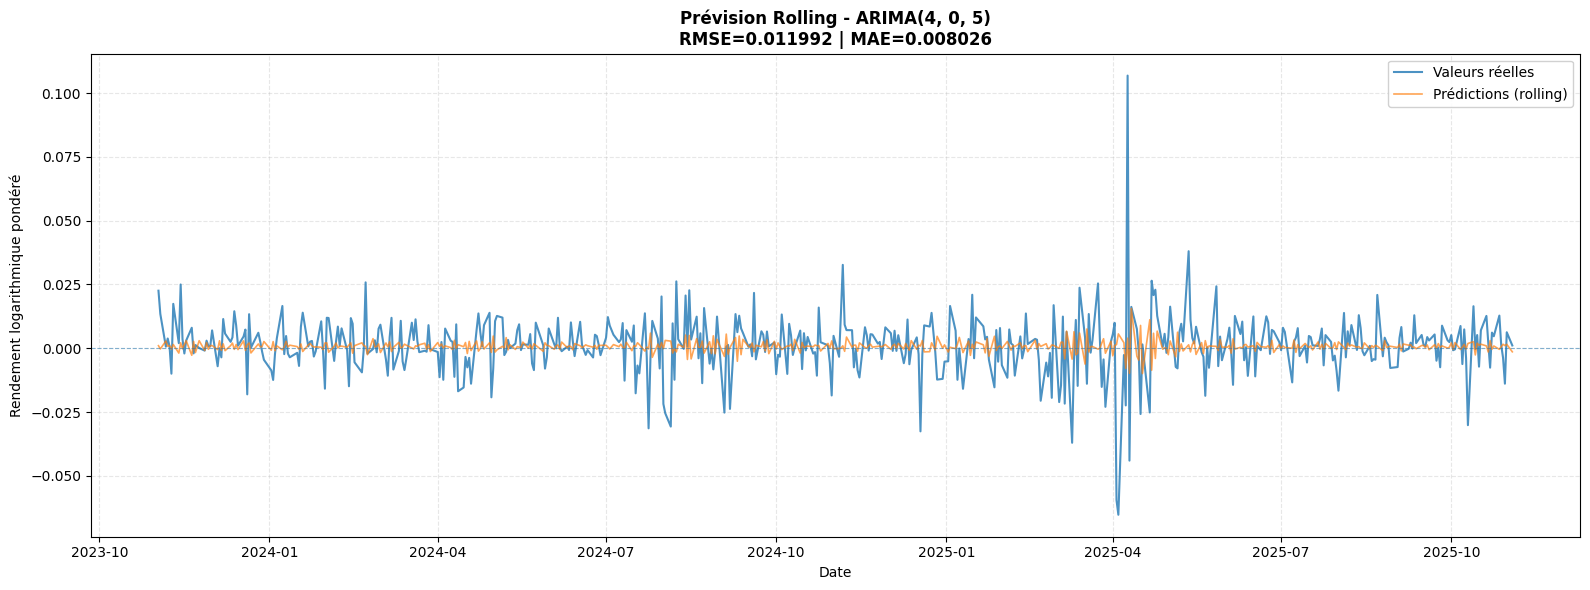

✓ Graphique sauvegardé : ../plots/rolling_forecast_arima_000.png


In [18]:
def plot_rolling_forecast_arima_000(test_series: pd.Series, actuals_baseline: np.ndarray, predictions_baseline: np.ndarray, baseline_order: tuple, metrics_baseline: dict):
    """
    Visualise les prédictions vs valeurs réelles pour ARIMA.
    """
    test_dates = test_series.index

    _, ax = plt.subplots(figsize=(16, 6))

    ax.plot(test_dates, actuals_baseline, label='Valeurs réelles', linewidth=1.5, alpha=0.8)
    ax.plot(test_dates, predictions_baseline, label='Prédictions (rolling)', linewidth=1.2, alpha=0.7)

    ax.axhline(0, linewidth=0.8, linestyle='--', alpha=0.5)

    ax.set_title(
        f'Prévision Rolling - ARIMA{baseline_order}\n'
        + f'RMSE={metrics_baseline["RMSE"]:.6f} | MAE={metrics_baseline["MAE"]:.6f}',
        fontsize=12,
        fontweight='bold',
    )
    ax.set_xlabel('Date', fontsize=10)
    ax.set_ylabel('Rendement logarithmique pondéré', fontsize=10)
    ax.legend(loc='best', framealpha=0.9)
    ax.grid(alpha=0.3, linestyle='--')

    plt.tight_layout()
    plt.savefig('../plots/rolling_forecast_arima_000.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ Graphique sauvegardé : ../plots/rolling_forecast_arima_000.png")

if __name__ == "__main__":
    print("\nÉTAPE 14: VISUALISATION DES PRÉDICTIONS ROLLING")
    plot_rolling_forecast_arima_000(test_series, actuals_baseline, predictions_baseline, baseline_order, metrics_baseline)


ÉTAPE 15: ANALYSE DES RÉSIDUS


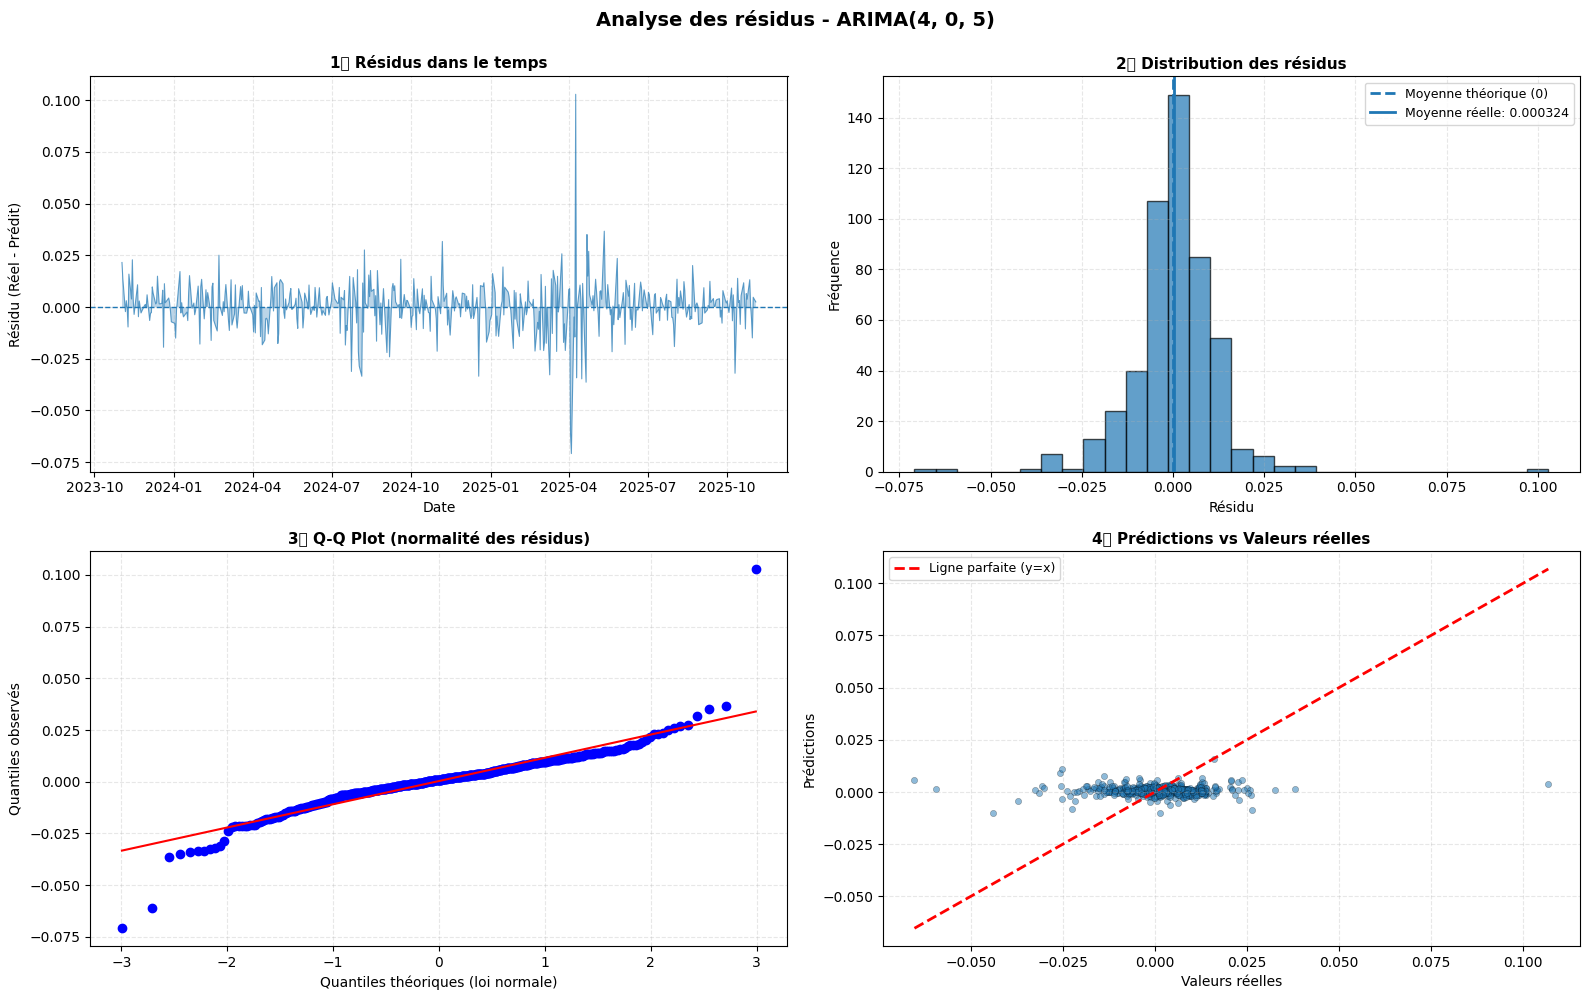

✓ Graphique sauvegardé : ../plots/residuals_analysis_arima_000.png


In [19]:
from scipy import stats as scipy_stats


def analyze_residuals_arima_000(test_series: pd.Series, actuals_baseline: np.ndarray, predictions_baseline: np.ndarray, baseline_order: tuple):
    """
    Analyse et visualisation des résidus pour ARIMA.
    """
    residuals_baseline = actuals_baseline - predictions_baseline
    test_dates = test_series.index

    _, axes = plt.subplots(2, 2, figsize=(16, 10))

    axes[0, 0].plot(test_dates, residuals_baseline, linewidth=0.8, alpha=0.7)
    axes[0, 0].axhline(0, linewidth=1, linestyle='--')
    axes[0, 0].fill_between(test_dates, 0, residuals_baseline, alpha=0.3)
    axes[0, 0].set_title('1️⃣ Résidus dans le temps', fontsize=11, fontweight='bold')
    axes[0, 0].set_xlabel('Date', fontsize=10)
    axes[0, 0].set_ylabel('Résidu (Réel - Prédit)', fontsize=10)
    axes[0, 0].grid(alpha=0.3, linestyle='--')

    axes[0, 1].hist(residuals_baseline, bins=30, alpha=0.7, edgecolor='black')
    axes[0, 1].axvline(0, linewidth=2, linestyle='--', label='Moyenne théorique (0)')
    axes[0, 1].axvline(np.mean(residuals_baseline), linewidth=2, linestyle='-',
                       label=f'Moyenne réelle: {np.mean(residuals_baseline):.6f}')
    axes[0, 1].set_title('2️⃣ Distribution des résidus', fontsize=11, fontweight='bold')
    axes[0, 1].set_xlabel('Résidu', fontsize=10)
    axes[0, 1].set_ylabel('Fréquence', fontsize=10)
    axes[0, 1].legend(fontsize=9)
    axes[0, 1].grid(alpha=0.3, linestyle='--')

    scipy_stats.probplot(residuals_baseline, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('3️⃣ Q-Q Plot (normalité des résidus)', fontsize=11, fontweight='bold')
    axes[1, 0].set_xlabel('Quantiles théoriques (loi normale)', fontsize=10)
    axes[1, 0].set_ylabel('Quantiles observés', fontsize=10)
    axes[1, 0].grid(alpha=0.3, linestyle='--')

    axes[1, 1].scatter(actuals_baseline, predictions_baseline, alpha=0.5, s=20, edgecolors='black', linewidth=0.3)
    axes[1, 1].plot([actuals_baseline.min(), actuals_baseline.max()],
                    [actuals_baseline.min(), actuals_baseline.max()],
                    'r--', linewidth=2, label='Ligne parfaite (y=x)')
    axes[1, 1].set_title('4️⃣ Prédictions vs Valeurs réelles', fontsize=11, fontweight='bold')
    axes[1, 1].set_xlabel('Valeurs réelles', fontsize=10)
    axes[1, 1].set_ylabel('Prédictions', fontsize=10)
    axes[1, 1].legend(fontsize=9)
    axes[1, 1].grid(alpha=0.3, linestyle='--')

    plt.suptitle(f'Analyse des résidus - ARIMA{baseline_order}',
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('../plots/residuals_analysis_arima_000.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ Graphique sauvegardé : ../plots/residuals_analysis_arima_000.png")

    return residuals_baseline

if __name__ == "__main__":
   print("\nÉTAPE 15: ANALYSE DES RÉSIDUS")
   residuals_baseline = analyze_residuals_arima_000(test_series, actuals_baseline, predictions_baseline, baseline_order)

In [20]:
def export_arima_000_results(test_series: pd.Series, actuals_baseline: np.ndarray, predictions_baseline: np.ndarray, residuals_baseline: np.ndarray, baseline_order: tuple, metrics_baseline: dict):
    """
    Export des prédictions et métriques pour le modèle ARIMA évalué.
    """
    import json

    test_dates = test_series.index

    predictions_df_baseline = pd.DataFrame({
        'date': test_dates,
        'actual': actuals_baseline,
        'predicted': predictions_baseline,
        'residual': residuals_baseline,
        'model': f'ARIMA{baseline_order}'
    })

    predictions_path_baseline = '../results/rolling_predictions_arima_000.csv'
    predictions_df_baseline.to_csv(predictions_path_baseline, index=False)

    rolling_metrics = {
        'model_arima': {
            'order': baseline_order,
            'params': f'ARIMA{baseline_order}',
            'description': 'Modèle ARIMA sélectionné (prévision des log-returns)',
            'metrics': {
                'MSE': float(metrics_baseline['MSE']),
                'RMSE': float(metrics_baseline['RMSE']),
                'MAE': float(metrics_baseline['MAE']),
            }
        },
        'test_size': len(test_series),
        'validation_method': 'rolling_window_walk_forward',
        'note': 'Validation dans l\'espace des log-returns'
    }

    metrics_path = '../results/rolling_validation_metrics_arima_000.json'
    with open(metrics_path, 'w') as f:
        json.dump(rolling_metrics, f, indent=2)

    print("=" * 60)
    print("EXPORT DES RÉSULTATS ARIMA")
    print("=" * 60)
    print(f"\n✓ Prédictions exportées : {predictions_path_baseline}")
    print(f"✓ Métriques exportées : {metrics_path}")
    print("=" * 60)

if __name__ == "__main__":
    print("\nÉTAPE 16: EXPORT DES RÉSULTATS ARIMA")
    export_arima_000_results(test_series, actuals_baseline, predictions_baseline, residuals_baseline, baseline_order, metrics_baseline)


ÉTAPE 16: EXPORT DES RÉSULTATS ARIMA
EXPORT DES RÉSULTATS ARIMA

✓ Prédictions exportées : ../results/rolling_predictions_arima_000.csv
✓ Métriques exportées : ../results/rolling_validation_metrics_arima_000.json


In [21]:
def implement_naive_model(train_series: pd.Series, test_series: pd.Series):
    """
    Implémentation du modèle naïf : prédiction = dernière valeur observée.
    """
    train_values = np.asarray(train_series.values)
    test_values = np.asarray(test_series.values)

    predictions_naive = []
    for idx, _ in enumerate(test_values):
        if idx == 0:
            predictions_naive.append(train_values[-1])
        else:
            predictions_naive.append(test_values[idx - 1])
    predictions_naive = np.asarray(predictions_naive)
    actuals_naive = test_values.copy()

    print("=" * 60)
    print("MODÈLE NAÏF (NAIVE BASELINE)")
    print("=" * 60)
    print("\nStratégie : prédire que le prochain log-return = dernier log-return observé")
    print("  Horizon : même nombre de points que le test set")
    print(f"  Nombre de prédictions : {len(predictions_naive)}")
    print("=" * 60)

    return predictions_naive, actuals_naive

if __name__ == "__main__":
    print("\nÉTAPE 17: IMPLÉMENTATION DU MODÈLE NAÏF")
    predictions_naive, actuals_naive = implement_naive_model(train_series, test_series)


ÉTAPE 17: IMPLÉMENTATION DU MODÈLE NAÏF
MODÈLE NAÏF (NAIVE BASELINE)

Stratégie : prédire que le prochain log-return = dernier log-return observé
  Horizon : même nombre de points que le test set
  Nombre de prédictions : 502


In [22]:
def evaluate_naive_model(predictions_naive: np.ndarray, actuals_naive: np.ndarray):
    """
    Calcul des métriques d'évaluation pour le modèle naïf.
    """
    mse_naive = mean_squared_error(actuals_naive, predictions_naive)
    rmse_naive = np.sqrt(mse_naive)
    mae_naive = mean_absolute_error(actuals_naive, predictions_naive)

    metrics_naive: Dict[str, float] = {
        'MSE': float(mse_naive),
        'RMSE': float(rmse_naive),
        'MAE': float(mae_naive),
    }

    print("\n" + "=" * 60)
    print("MÉTRIQUES D'ÉVALUATION - MODÈLE NAÏF")
    print("=" * 60)
    print(f"\n  MSE  : {metrics_naive['MSE']:.8f}")
    print(f"  RMSE : {metrics_naive['RMSE']:.8f}")
    print(f"  MAE  : {metrics_naive['MAE']:.8f}")
    print("=" * 60)

    return metrics_naive

if __name__ == "__main__":
    print("\nÉTAPE 18: ÉVALUATION DU MODÈLE NAÏF")
    metrics_naive = evaluate_naive_model(predictions_naive, actuals_naive)


ÉTAPE 18: ÉVALUATION DU MODÈLE NAÏF

MÉTRIQUES D'ÉVALUATION - MODÈLE NAÏF

  MSE  : 0.00030018
  RMSE : 0.01732574
  MAE  : 0.01158555


In [23]:
def compare_models(metrics_baseline: dict, metrics_naive: dict, baseline_order: tuple):
    """
    Comparaison des performances : ARIMA(p,d,q) vs Modèle Naïf.
    """
    print("=" * 60)
    print("COMPARAISON DES MODÈLES")
    print("=" * 60)

    arima_label = f"ARIMA{baseline_order}"

    print(f"\n{'Métrique':<10} {arima_label:<15} {'Naïf':<15} {'Différence':<15}")
    print("-" * 60)

    diff_mse = metrics_baseline['MSE'] - metrics_naive['MSE']
    print(f"{'MSE':<10} {metrics_baseline['MSE']:>14.8f} {metrics_naive['MSE']:>14.8f} {diff_mse:>+14.8f}")

    diff_rmse = metrics_baseline['RMSE'] - metrics_naive['RMSE']
    print(f"{'RMSE':<10} {metrics_baseline['RMSE']:>14.8f} {metrics_naive['RMSE']:>14.8f} {diff_rmse:>+14.8f}")

    diff_mae = metrics_baseline['MAE'] - metrics_naive['MAE']
    print(f"{'MAE':<10} {metrics_baseline['MAE']:>14.8f} {metrics_naive['MAE']:>14.8f} {diff_mae:>+14.8f}")

    print("-" * 60)

    if metrics_baseline['RMSE'] < metrics_naive['RMSE']:
        improvement = ((metrics_naive['RMSE'] - metrics_baseline['RMSE']) / metrics_naive['RMSE']) * 100
        print(f"\n✓ {arima_label} améliore le modèle naïf de {improvement:.2f}% (RMSE)")
    else:
        degradation = ((metrics_baseline['RMSE'] - metrics_naive['RMSE']) / metrics_naive['RMSE']) * 100
        print(f"\n⚠ {arima_label} est {degradation:.2f}% moins performant que le modèle naïf (RMSE)")

    print("=" * 60)

if __name__ == "__main__":
    print("\nÉTAPE 19: COMPARAISON DES MODÈLES")
    compare_models(metrics_baseline, metrics_naive, baseline_order)


ÉTAPE 19: COMPARAISON DES MODÈLES
COMPARAISON DES MODÈLES

Métrique   ARIMA(4, 0, 5)  Naïf            Différence     
------------------------------------------------------------
MSE            0.00014380     0.00030018    -0.00015638
RMSE           0.01199178     0.01732574    -0.00533396
MAE            0.00802577     0.01158555    -0.00355978
------------------------------------------------------------

✓ ARIMA(4, 0, 5) améliore le modèle naïf de 30.79% (RMSE)


In [24]:
def export_naive_results(test_series: pd.Series, predictions_naive: np.ndarray, actuals_naive: np.ndarray, metrics_naive: dict, metrics_baseline: dict, baseline_order: tuple):
    """
    Export des résultats du modèle naïf pour comparaison future.
    """
    import json

    test_dates_naive = test_series.index

    predictions_df_naive = pd.DataFrame({
        'date': test_dates_naive,
        'actual': actuals_naive,
        'predicted': predictions_naive,
        'residual': actuals_naive - predictions_naive,
        'model': 'Naive_last_value'
    })

    predictions_path_naive = '../results/rolling_predictions_naive_last_value.csv'
    predictions_df_naive.to_csv(predictions_path_naive, index=False)

    naive_metrics_export = {
        'model_naive_last_value': {
            'description': 'Prédiction du log-return par dernière valeur observée',
            'formula': 'ŷ(t+1) = y(t)',
            'metrics': {
                'MSE': float(metrics_naive['MSE']),
                'RMSE': float(metrics_naive['RMSE']),
                'MAE': float(metrics_naive['MAE']),
            }
        },
        'comparison_with_arima': {
            'arima_order': baseline_order,
            'arima_RMSE': float(metrics_baseline['RMSE']),
            'naive_RMSE': float(metrics_naive['RMSE']),
            'difference_RMSE': float(metrics_baseline['RMSE'] - metrics_naive['RMSE']),
            'improvement_pct': float(((metrics_naive['RMSE'] - metrics_baseline['RMSE']) / metrics_naive['RMSE']) * 100)
        },
        'test_size': len(predictions_naive)
    }

    metrics_path_naive = '../results/naive_last_value_metrics.json'
    with open(metrics_path_naive, 'w') as f:
        json.dump(naive_metrics_export, f, indent=2)

    print("=" * 60)
    print("EXPORT DES RÉSULTATS - MODÈLE NAÏF")
    print("=" * 60)
    print(f"\n✓ Prédictions exportées : {predictions_path_naive}")
    print(f"✓ Métriques exportées : {metrics_path_naive}")
    print("=" * 60)

if __name__ == "__main__":
    print("\nÉTAPE 20: EXPORT DES RÉSULTATS DU MODÈLE NAÏF")
    export_naive_results(test_series, predictions_naive, actuals_naive, metrics_naive, metrics_baseline, baseline_order)


ÉTAPE 20: EXPORT DES RÉSULTATS DU MODÈLE NAÏF
EXPORT DES RÉSULTATS - MODÈLE NAÏF

✓ Prédictions exportées : ../results/rolling_predictions_naive_last_value.csv
✓ Métriques exportées : ../results/naive_last_value_metrics.json


In [25]:
def backtest_strategies():
    """
    Backtest des stratégies de trading : ARIMA vs Naïf vs Buy & Hold.
    Portefeuille initial : 10 000 €. Même coût de transaction pour toutes les stratégies.
    Les signaux sont des prévisions de log-return à J, utilisées pour décider d'être
    long / cash à l'ouverture de J.
    """
    import json

    print("=" * 80)
    print("BACKTEST DES STRATÉGIES DE TRADING")
    print("=" * 80)

    INITIAL_CAPITAL = 10_000.0
    TRANSACTION_COST = 0.001  # 0.1% par transaction
    SIGNAL_THRESHOLD = TRANSACTION_COST  # seuil sur |pred_return|

    test_data = pd.read_csv('../data/weighted_log_returns_split.csv', parse_dates=['date'])
    test_data = test_data[test_data['split'] == 'test'].copy()
    test_data = test_data.sort_values('date').reset_index(drop=True)

    arima_predictions = pd.read_csv('../results/rolling_predictions_arima_000.csv', parse_dates=['date'])
    naive_predictions = pd.read_csv('../results/rolling_predictions_naive_last_value.csv', parse_dates=['date'])

    test_data = test_data.merge(
        arima_predictions[['date', 'predicted']], on='date', how='left'
    )
    test_data = test_data.rename(columns={'predicted': 'pred_arima'})

    test_data = test_data.merge(
        naive_predictions[['date', 'predicted']], on='date', how='left'
    )
    test_data = test_data.rename(columns={'predicted': 'pred_naive'})

    def prediction_diagnostics(df, pred_col, label):
        preds = df[pred_col].dropna()
        if preds.empty:
            print(f"⚠ Aucun prédictif disponible pour {label}")
            return {}
        mean = preds.mean()
        std = preds.std()
        n_gt_cost = (preds.abs() > TRANSACTION_COST).sum()
        pct_gt_cost = n_gt_cost / len(preds) * 100

        df_valid = df.dropna(subset=[pred_col, 'weighted_log_return'])
        if not df_valid.empty:
            sign_match = (np.sign(df_valid[pred_col]) == np.sign(df_valid['weighted_log_return']))
            directional_acc = sign_match.mean() * 100
        else:
            directional_acc = float('nan')

        print(f"Diagnostics {label} -> mean={mean:.6f}, std={std:.6f}, |pred|>cost: {n_gt_cost}/{len(preds)} ({pct_gt_cost:.1f}%), directional acc: {directional_acc:.1f}%")
        return {
            'mean': float(mean),
            'std': float(std),
            'n_gt_cost': int(n_gt_cost),
            'pct_gt_cost': float(pct_gt_cost),
            'directional_acc_pct': float(directional_acc)
        }

    print('\nDIAGNOSTICS DES PRÉDICTIONS')
    print('-' * 60)
    diag_arima = prediction_diagnostics(test_data, 'pred_arima', 'ARIMA')
    diag_naive = prediction_diagnostics(test_data, 'pred_naive', 'Naïf')
    print('-' * 60 + '\n')

    print(f"Données de test : {len(test_data)} jours")
    print(f"Période : {test_data['date'].min().date()} → {test_data['date'].max().date()}")
    print(f"Capital initial : {INITIAL_CAPITAL:,.0f} €")
    print(f"Coût transaction : {TRANSACTION_COST * 100:.2f}%")
    print(f"Seuil de signal : {SIGNAL_THRESHOLD * 100:.2f}% en valeur absolue de log-return")
    print("=" * 80)

    # Retourner les objets utiles pour l'orchestration extérieure
    return test_data, INITIAL_CAPITAL, TRANSACTION_COST, SIGNAL_THRESHOLD, diag_arima, diag_naive

if __name__ == "__main__":
    print("\nÉTAPE 21: BACKTEST DES STRATÉGIES DE TRADING")
    backtest_strategies()


ÉTAPE 21: BACKTEST DES STRATÉGIES DE TRADING
BACKTEST DES STRATÉGIES DE TRADING

DIAGNOSTICS DES PRÉDICTIONS
------------------------------------------------------------
Diagnostics ARIMA -> mean=0.000726, std=0.002215, |pred|>cost: 284/502 (56.6%), directional acc: 52.0%
Diagnostics Naïf -> mean=0.001074, std=0.011840, |pred|>cost: 447/502 (89.0%), directional acc: 51.4%
------------------------------------------------------------

Données de test : 502 jours
Période : 2023-11-02 → 2025-11-03
Capital initial : 10,000 €
Coût transaction : 0.10%
Seuil de signal : 0.10% en valeur absolue de log-return


In [26]:
def backtest_strategy(pred_col: str, strategy_name: str, test_data: pd.DataFrame, INITIAL_CAPITAL: float, TRANSACTION_COST: float, SIGNAL_THRESHOLD: float) -> Dict:
        capital = INITIAL_CAPITAL
        position = 0.0
        trades = []
        equity_curve = []

        for idx, row in test_data.iterrows():
            date = row['date']
            pred_return = row[pred_col]
            open_price = row['weighted_open']
            close_price = row['weighted_closing']

            if np.isnan(open_price) or np.isnan(close_price):
                continue

            if np.isnan(pred_return):
                portfolio_value = capital + position * close_price
                equity_curve.append({'date': date, 'value': float(portfolio_value)})
                continue

            # Décision
            target_long = 0
            if pred_return > SIGNAL_THRESHOLD:
                target_long = 1
            elif pred_return < -SIGNAL_THRESHOLD:
                target_long = 0
            else:
                target_long = 1 if position > 0 else 0

            # Achat
            if target_long == 1 and position == 0:
                shares_to_buy = capital / (open_price * (1 + TRANSACTION_COST))
                if shares_to_buy > 0:
                    cost = shares_to_buy * open_price * (1 + TRANSACTION_COST)
                    capital -= cost
                    position = shares_to_buy
                    trades.append({
                        'date': date,
                        'action': 'BUY',
                        'price': float(open_price),
                        'shares': float(shares_to_buy),
                        'cost': float(cost),
                        'capital_after': float(capital)
                    })

            # Vente
            elif target_long == 0 and position > 0:
                sale_value = position * open_price * (1 - TRANSACTION_COST)
                capital += sale_value
                trades.append({
                    'date': date,
                    'action': 'SELL',
                    'price': float(open_price),
                    'shares': float(position),
                    'value': float(sale_value),
                    'capital_after': float(capital)
                })
                position = 0.0

            portfolio_value = capital + position * close_price
            equity_curve.append({'date': date, 'value': float(portfolio_value)})

        # Clôture forcée à la fin
        if position > 0:
            final_row = test_data.iloc[-1]
            final_price = final_row['weighted_closing']
            sale_value = position * final_price * (1 - TRANSACTION_COST)
            capital += sale_value
            trades.append({
                'date': final_row['date'],
                'action': 'SELL_FINAL',
                'price': float(final_price),
                'shares': float(position),
                'value': float(sale_value),
                'capital_after': float(capital)
            })
            position = 0.0
            if equity_curve:
                equity_curve[-1]['value'] = float(capital)

        return {
            'strategy': strategy_name,
            'final_capital': float(capital),
            'total_return': float((capital - INITIAL_CAPITAL) / INITIAL_CAPITAL * 100),
            'trades': trades,
            'num_trades': len([t for t in trades if t['action'] in ['BUY', 'SELL']]),
            'equity_curve': equity_curve
        }

In [27]:
def backtest_buy_hold(test_data: pd.DataFrame, INITIAL_CAPITAL: float, TRANSACTION_COST: float) -> Dict:
    first_row = test_data.iloc[0]
    last_row = test_data.iloc[-1]

    buy_price = first_row['weighted_open']
    sell_price = last_row['weighted_closing']

    shares = INITIAL_CAPITAL / (buy_price * (1 + TRANSACTION_COST))
    capital_after_buy = INITIAL_CAPITAL - shares * buy_price * (1 + TRANSACTION_COST)

    final_value_gross = shares * sell_price
    final_value = capital_after_buy + final_value_gross * (1 - TRANSACTION_COST)

    trades = [
        {
            'date': first_row['date'],
            'action': 'BUY_HOLD',
            'price': float(buy_price),
            'shares': float(shares),
            'cost': float(shares * buy_price * (1 + TRANSACTION_COST)),
            'capital_after': float(capital_after_buy)
        },
        {
            'date': last_row['date'],
            'action': 'SELL_HOLD',
            'price': float(sell_price),
            'value': float(final_value),
            'capital_after': float(final_value)
        }
    ]

    equity_curve = []
    for _, row in test_data.iterrows():
        date = row['date']
        close_price = row['weighted_closing']
        value = capital_after_buy + shares * close_price
        equity_curve.append({'date': date, 'value': float(value)})

    if equity_curve:
        equity_curve[-1]['value'] = float(final_value)

    return {
        'strategy': 'Buy & Hold',
        'final_capital': float(final_value),
        'total_return': float((final_value - INITIAL_CAPITAL) / INITIAL_CAPITAL * 100),
        'trades': trades,
        'num_trades': 2,
        'equity_curve': equity_curve
    }

# Orchestration : préparer les données et lancer les backtests
import json

test_data, INITIAL_CAPITAL, TRANSACTION_COST, SIGNAL_THRESHOLD, diag_arima, diag_naive = backtest_strategies()

arima_results = backtest_strategy('pred_arima', 'ARIMA', test_data, INITIAL_CAPITAL, TRANSACTION_COST, SIGNAL_THRESHOLD)
naive_results = backtest_strategy('pred_naive', 'Naïf', test_data, INITIAL_CAPITAL, TRANSACTION_COST, SIGNAL_THRESHOLD)
buy_hold_results = backtest_buy_hold(test_data, INITIAL_CAPITAL, TRANSACTION_COST)

print("RÉSULTATS DES BACKTESTS")
print("=" * 80)

strategies = [
    ('Buy & Hold', buy_hold_results),
    ('ARIMA', arima_results),
    ('Naïf', naive_results)
]

for name, results in strategies:
    print(f"\n{name}:")
    print(f"  Capital final : {results['final_capital']:,.2f} €")
    print(f"  Rendement total : {results['total_return']:+.2f}%")
    print(f"  Nombre de trades : {results['num_trades']}")

print("\n" + "=" * 80)
print("COMPARAISON")
print("=" * 80)

sorted_strategies = sorted(strategies, key=lambda x: x[1]['total_return'], reverse=True)

print("Classement par rendement :")
for i, (name, results) in enumerate(sorted_strategies, 1):
    print(f"{i}. {name}: {results['total_return']:+.2f}%")

best_name, best_results = sorted_strategies[0]
print(f"\n✓ Meilleure stratégie : {best_name} ({best_results['total_return']:+.2f}%)")

backtest_summary = {
    'initial_capital': INITIAL_CAPITAL,
    'transaction_cost': TRANSACTION_COST,
    'signal_threshold': SIGNAL_THRESHOLD,
    'test_period': {
        'start': test_data['date'].min().date().isoformat(),
        'end': test_data['date'].max().date().isoformat(),
        'days': int(len(test_data))
    },
    'strategies': {
        'buy_hold': {
            'final_capital': float(buy_hold_results['final_capital']),
            'total_return_pct': float(buy_hold_results['total_return']),
            'num_trades': int(buy_hold_results['num_trades'])
        },
        'arima': {
            'final_capital': float(arima_results['final_capital']),
            'total_return_pct': float(arima_results['total_return']),
            'num_trades': int(arima_results['num_trades'])
        },
        'naive': {
            'final_capital': float(naive_results['final_capital']),
            'total_return_pct': float(naive_results['total_return']),
            'num_trades': int(naive_results['num_trades'])
        }
    },
    'diagnostics': {
        'arima': diag_arima,
        'naive': diag_naive
    }
}

with open('../results/backtest_results.json', 'w') as f:
    json.dump(backtest_summary, f, indent=2)

print(f"\n✓ Résultats détaillés exportés : ../results/backtest_results.json")
print("=" * 80)
print("\n" + "=" * 80)
print("✓ PIPELINE TERMINÉE AVEC SUCCÈS")
print("  Consultez les dossiers data/, results/ et plots/ pour les résultats")
print("=" * 80)

BACKTEST DES STRATÉGIES DE TRADING

DIAGNOSTICS DES PRÉDICTIONS
------------------------------------------------------------
Diagnostics ARIMA -> mean=0.000726, std=0.002215, |pred|>cost: 284/502 (56.6%), directional acc: 52.0%
Diagnostics Naïf -> mean=0.001074, std=0.011840, |pred|>cost: 447/502 (89.0%), directional acc: 51.4%
------------------------------------------------------------

Données de test : 502 jours
Période : 2023-11-02 → 2025-11-03
Capital initial : 10,000 €
Coût transaction : 0.10%
Seuil de signal : 0.10% en valeur absolue de log-return
RÉSULTATS DES BACKTESTS

Buy & Hold:
  Capital final : 16,694.87 €
  Rendement total : +66.95%
  Nombre de trades : 2

ARIMA:
  Capital final : 14,595.34 €
  Rendement total : +45.95%
  Nombre de trades : 140

Naïf:
  Capital final : 8,838.50 €
  Rendement total : -11.61%
  Nombre de trades : 207

COMPARAISON
Classement par rendement :
1. Buy & Hold: +66.95%
2. ARIMA: +45.95%
3. Naïf: -11.61%

✓ Meilleure stratégie : Buy & Hold (+66.9